# 1. Configuração do ambiente

In [ ]:
!pip install opencv-python numpy google-cloud-storage

In [ ]:
!pip install google-cloud-vision
!pip install tensorflow-io

In [ ]:
!pip install gcsfs

In [ ]:
!pip install --upgrade tensorflow keras protobuf
!pip install --upgrade google-cloud-storage

In [5]:
import numpy as np
import cv2
from google.cloud import storage
from google.cloud import vision
import io
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import shutil
import pathlib
import seaborn as sns

In [6]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Activation
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools

In [7]:
# Inicializa o cliente do GCS
BUCKET_NAME = 'moedasbrasileiras'
storage_client = storage.Client()
bucket = storage_client.bucket(BUCKET_NAME)
vision_client = vision.ImageAnnotatorClient()


# Treinamento

In [8]:
#1. CONFIGURAÇÕES E PARÂMETROS

# Informações do Bucket GCS
BUCKET_NAME = 'moedasbrasileiras'
DATA_DIR_GCS = f'gs://{BUCKET_NAME}/classes/'

# Parâmetros de Treinamento
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 0.0001
NUM_EPOCHS = 250
AUTOTUNE = tf.data.AUTOTUNE # Otimização de I/O

# Nomes das classes (baseados nas subpastas)
CLASS_NAMES = ['cincocentavos', 'cinquentacentavos', 'dezcentavos',
               'umcentavo', 'umreal', 'vinteecincocentavos']
NUM_CLASSES = len(CLASS_NAMES)

# Inicializa os clientes (Para autenticação GCS)
try:
    storage_client = storage.Client()
    bucket = storage_client.bucket(BUCKET_NAME)
    vision_client = vision.ImageAnnotatorClient()
except Exception as e:
    print(f"Aviso: Falha ao inicializar clientes GCS/Vision. O acesso ao GCS pode falhar se o ambiente não estiver autenticado. Erro: {e}")


In [9]:
# 2. FUNÇÕES PARA tf.data.Dataset

def get_label(filepath):
    """Extrai o nome da classe do caminho do arquivo e converte para one-hot."""
    parts = tf.strings.split(filepath, os.path.sep)
    class_name = parts[-2]
    return tf.cast(class_name == CLASS_NAMES, tf.float32)

def decode_img(img_bytes):
    """Decodifica, redimensiona e normaliza (rescale=1./255) a imagem.
       Adiciona tratamento para diferentes formatos de imagem."""

    # Decodificação robusta:
    image = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)

    # Redimensionamento
    image = tf.image.resize(image, TARGET_SIZE)

    # Normalização
    return image / 255.0

def apply_augmentation(img, label):
    """Implementa as transformações de Data Augmentation."""
    # Rotação (rotation_range=7) - implementado como rotação aleatória (simples)
    img = tf.image.rot90(img, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    # Flip Horizontal (horizontal_flip=True)
    img = tf.image.random_flip_left_right(img)
    return img, label

def process_path(filepath):
    """Processa o caminho do arquivo para obter a imagem e o rótulo."""
    label = get_label(filepath)
    # tf.io.read_file é seguro para caminhos GCS
    img_bytes = tf.io.read_file(filepath)
    img = decode_img(img_bytes)
    return img, label


In [10]:
# 3. CRIAÇÃO E CONFIGURAÇÃO DO DATASET

# Lista todos os arquivos (incluindo subpastas)
# Lista arquivos JPEG
jpg_ds = tf.data.Dataset.list_files(str(DATA_DIR_GCS + '*/' + '*.jpg'))
jpeg_ds = tf.data.Dataset.list_files(str(DATA_DIR_GCS + '*/' + '*.jpeg'))

# Lista arquivos PNG (se houver)
png_ds = tf.data.Dataset.list_files(str(DATA_DIR_GCS + '*/' + '*.png'))

# Concatena todos os Datasets de imagem válidos
list_ds = jpg_ds.concatenate(jpeg_ds).concatenate(png_ds)

# Determina o tamanho do dataset e mapeia
DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

# Mapeia os caminhos para as imagens e rótulos
ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# Separação Treinamento/Validação (80%/20%)
TRAIN_SIZE = int((1 - VALIDATION_SPLIT) * DATASET_SIZE)

train_ds = ds.take(TRAIN_SIZE).cache()
val_ds = ds.skip(TRAIN_SIZE).cache()

# Aplica aumento de dados SÓ no conjunto de treinamento
train_ds = train_ds.map(apply_augmentation, num_parallel_calls=AUTOTUNE)

# Configuração final do pipeline
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).repeat().prefetch(AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print(f"\n--- Detecção de Dados ---")
print(f"Total de imagens detectadas: {DATASET_SIZE}")
print(f"Imagens para Treinamento: {TRAIN_SIZE}")
print(f"Imagens para Validação: {DATASET_SIZE - TRAIN_SIZE}")
print(f"Classes: {CLASS_NAMES}")



--- Detecção de Dados ---
Total de imagens detectadas: 186
Imagens para Treinamento: 148
Imagens para Validação: 38
Classes: ['cincocentavos', 'cinquentacentavos', 'dezcentavos', 'umcentavo', 'umreal', 'vinteecincocentavos']


In [11]:
# 4. CONSTRUÇÃO E COMPILAÇÃO DO MODELO

# Criação do Modelo MobileNetV2 (Transfer Learning)
base_model = MobileNetV2(
    input_shape=(*TARGET_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Congela TODAS as camadas do modelo base para Fine-Tuning
for layer in base_model.layers:
    layer.trainable = False

# Adicionar as Camadas Finais (Head)
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compilação do Modelo
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=adam_optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\n--- Sumário do Modelo ---")
model.summary()



--- Sumário do Modelo ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,265,670 (8.64 MB)

 Trainable params: 7,686 (30.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
# 5. TREINAMENTO DO MODELO
print(f"\n--- Iniciando Treinamento ({NUM_EPOCHS} Épocas) ---")

steps_per_epoch_train = TRAIN_SIZE // BATCH_SIZE
steps_per_epoch_val = (DATASET_SIZE - TRAIN_SIZE) // BATCH_SIZE

history = model.fit(
    train_ds,
    steps_per_epoch=steps_per_epoch_train,
    epochs=NUM_EPOCHS,
    validation_data=val_ds,
    validation_steps=steps_per_epoch_val
)

print("\nTreinamento concluído!")


--- Iniciando Treinamento (250 Épocas) ---
Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 5s/step - accuracy: 0.1484 - loss: 2.1610 - val_accuracy: 0.1250 - val_loss: 2.1713
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - accuracy: 0.1207 - loss: 2.2343 - val_accuracy: 0.0938 - val_loss: 2.0929
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.1207 - loss: 2.0521 - val_accuracy: 0.1875 - val_loss: 2.0288
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 904ms/step - accuracy: 0.1810 - loss: 1.9658 - val_accuracy: 0.1875 - val_loss: 1.9779
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1897 - loss: 1.9413 - val_accuracy: 0.1875 - val_loss: 1.9349
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.2422 - loss: 1.8426 - val_accuracy: 0.2188 - val_loss: 1.9006
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2155 - loss: 1.9005 - val_accuracy: 0.2188 - val_loss: 1.8712
Epoch 8/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.1983 - loss: 1.9481 -

# Validação

In [13]:
# Criei um conjunto de teste final a partir do seu dataset de validação
# Usei .unbatch() e .map() para preparar os dados para o Scikit-Learn
test_ds = val_ds.unbatch()

# Extrai as imagens e os rótulos verdadeiros
y_true = []
test_images = []

# Iterar sobre o Dataset para coletar os dados
# ATENÇÃO: Se o val_ds for muito grande, essa etapa pode levar tempo!
for image, label in test_ds:
    test_images.append(image.numpy())
    # O rótulo é um vetor one-hot, precisamos do índice (argmax)
    y_true.append(np.argmax(label.numpy()))

# Converte a lista de imagens de volta para um array NumPy
test_images = np.array(test_images)
y_true = np.array(y_true)


#Fazer as Previsões com o Modelo Treinado
# model.predict retorna as probabilidades (vetor one-hot)
y_pred_probs = model.predict(test_images, batch_size=BATCH_SIZE)

# Converte as probabilidades em classes (o índice de maior probabilidade)
y_pred = np.argmax(y_pred_probs, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step



 Resultado da Matriz de Confusão
[[7 0 2 2 1 0]
 [0 3 2 1 0 0]
 [2 0 3 2 2 0]
 [1 0 2 1 1 0]
 [0 0 0 0 5 0]
 [0 0 0 0 0 1]]


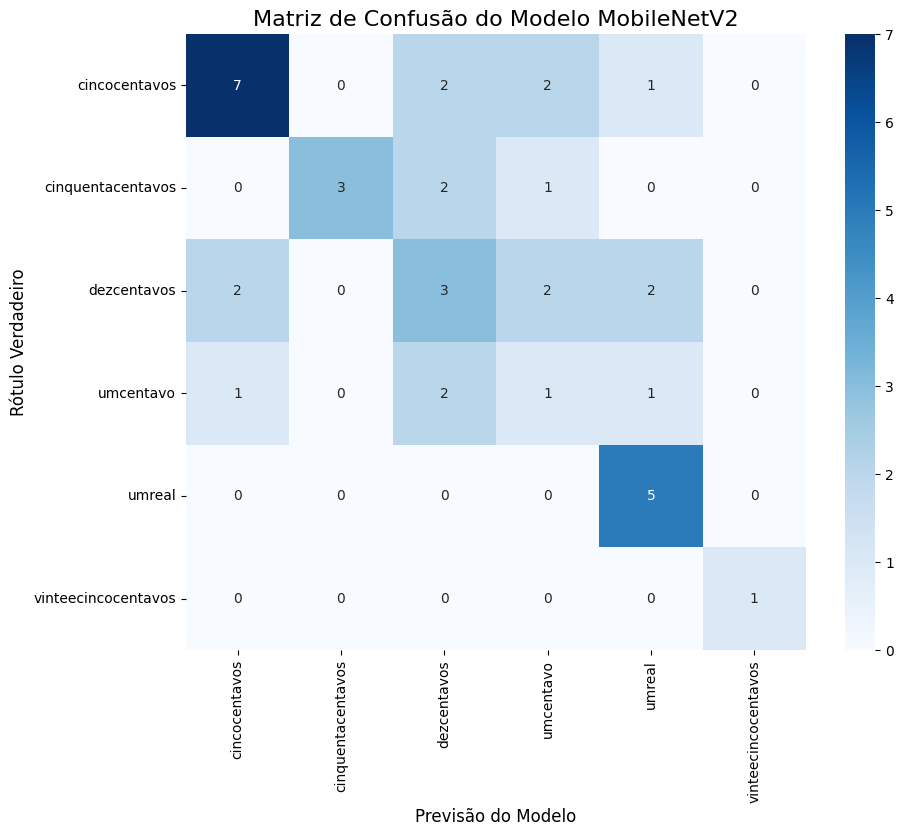

In [14]:
#  Gerar e Plotar a Matriz de Confusão
cm = confusion_matrix(y_true, y_pred)
class_names = CLASS_NAMES

print("\n Resultado da Matriz de Confusão")
print(cm)

# Plotagem Estilizada
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Matriz de Confusão do Modelo MobileNetV2', fontsize=16)
plt.ylabel('Rótulo Verdadeiro', fontsize=12)
plt.xlabel('Previsão do Modelo', fontsize=12)
plt.yticks(rotation=0)
plt.show()

Gerando gráficos de Desempenho do Modelo...


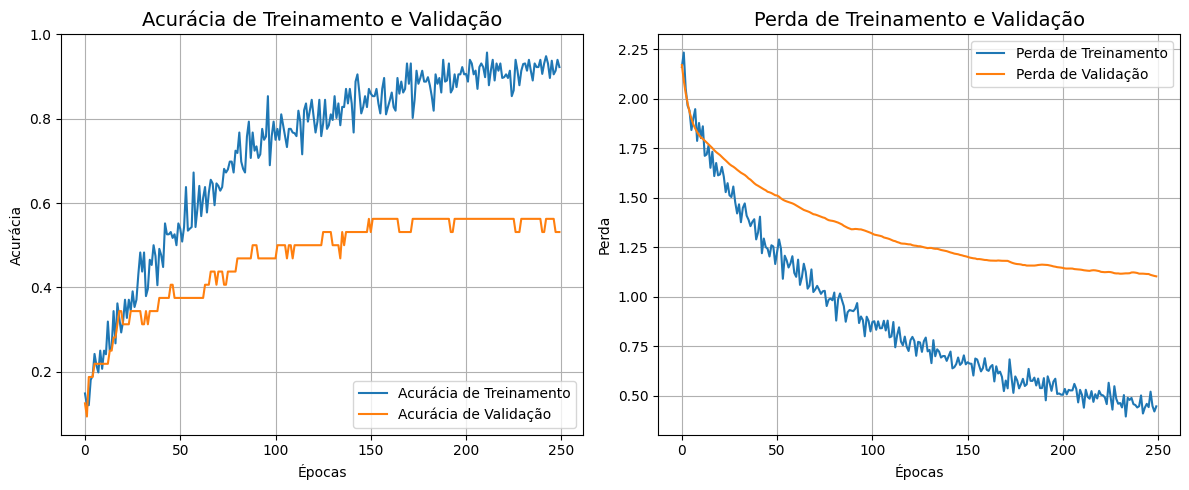

In [17]:
if 'history' in locals() and history is not None:

    # Extrai os dados do histórico
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Cria o array de épocas
    epochs_range = range(len(acc))

    print("Gerando gráficos de Desempenho do Modelo...")

    ## 1. Gráfico de Acurácia
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1) # 1 linha, 2 colunas, 1ª posição
    plt.plot(epochs_range, acc, label='Acurácia de Treinamento')
    plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
    plt.legend(loc='lower right')
    plt.title('Acurácia de Treinamento e Validação', fontsize=14)
    plt.xlabel('Épocas')
    plt.ylabel('Acurácia')
    plt.grid(True)

    ## 2. Gráfico de Perda
    plt.subplot(1, 2, 2) # 1 linha, 2 colunas, 2ª posição
    plt.plot(epochs_range, loss, label='Perda de Treinamento')
    plt.plot(epochs_range, val_loss, label='Perda de Validação')
    plt.legend(loc='upper right')
    plt.title('Perda de Treinamento e Validação', fontsize=14)
    plt.xlabel('Épocas')
    plt.ylabel('Perda')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    #

else:
    print("Erro: O objeto 'history' não foi encontrado. Certifique-se de que o treinamento (model.fit) foi concluído com sucesso e que o resultado foi armazenado na variável 'history'.")